In [1]:
import os
import json
import yaml
import numpy as np
import pandas as pd

from tensorboard.backend.event_processing import event_accumulator

In [2]:
def get_metrics_dict(model_dir):
    """Parse metrics from metrics_excel.txt file with format:
    metric:, LP_mean(LP_std), RP_mean(RP_std), BTI_mean(BTI_std)
    """
    metrics_file = f"{model_dir}/metrics_excel.txt"
    
    try:
        with open(metrics_file, 'r') as f:
            lines = f.readlines()
            
        # Initialize storage for metrics
        metrics = {}
        for line in lines:
            metric, lp, rp, bti = line.strip().split(',')
            metric = metric.replace(':', '').strip()
            
            # Extract mean and std from formatted strings like "0.71290(0.10430)"
            def extract_mean_std(value):
                value = value.strip()
                mean = float(value.split('(')[0])
                std = float(value.split('(')[1].replace(')', ''))
                return mean, std
            
            lp_mean, lp_std = extract_mean_std(lp)
            rp_mean, rp_std = extract_mean_std(rp)
            bti_mean, bti_std = extract_mean_std(bti)
            
            metrics[metric] = {
                'lp_mean': lp_mean, 'lp_std': lp_std,
                'rp_mean': rp_mean, 'rp_std': rp_std,
                'bti_mean': bti_mean, 'bti_std': bti_std
            }
        
        return (metrics['MSE']['rp_mean'], metrics['MSE']['rp_std'],
                metrics['SCC']['rp_mean'], metrics['SCC']['rp_std'],
                metrics['TCC']['rp_mean'], metrics['TCC']['rp_std'],
                metrics['MSE']['lp_mean'], metrics['MSE']['lp_std'],
                metrics['SCC']['lp_mean'], metrics['SCC']['lp_std'],
                metrics['TCC']['lp_mean'], metrics['TCC']['lp_std'],
                metrics['MSE']['bti_mean'], metrics['MSE']['bti_std'],
                metrics['SCC']['bti_mean'], metrics['SCC']['bti_std'],
                metrics['TCC']['bti_mean'], metrics['TCC']['bti_std'])
                
    except Exception as e:
        print(f"Error reading metrics file {metrics_file}: {str(e)}")
        raise e

In [3]:
seed = 125125125


In [4]:
def get_highest_version(base_path):
    """Find the highest version folder in the given path"""
    try:
        # List all directories matching version_* pattern
        version_dirs = [d for d in os.listdir(base_path) 
                       if d.startswith('version_') and 'copy' not in d.lower()]
        if not version_dirs:
            return None
        
        # Extract version numbers and find max
        versions = [int(d.split('_')[1]) for d in version_dirs]
        highest_version = max(versions)
        return f"version_{highest_version}"
    except Exception as e:
        print(f"Error finding highest version in {base_path}: {e}")
        return None

metrics = {}
base_path = "../experiments"
dataset = "synthetic"

# Define the list of seeds to process
seeds = [1111, 2222, 3333, 4444, 5555]

# Define base model paths without version
models = {
    "CoMetaPNS": {
        "NL": f"{base_path}/feedforwardmask_{dataset}_continual_naive_SEED_1.0/feedforwardmask",
        "RS": f"{base_path}/feedforwardmask_{dataset}_continual_task_aware_SEED_1.0/feedforwardmask",
        "ER": f"{base_path}/feedforwardmask_{dataset}_continual_er_SEED_1.0/feedforwardmask"
    },
    "MAML-PNS": {
        "NL": f"{base_path}/maml_{dataset}_continual_naive_SEED_1.0/maml",
        "RS": f"{base_path}/maml_{dataset}_continual_task_aware_SEED_1.0/maml",
        "ER": f"{base_path}/maml_{dataset}_continual_er_SEED_1.0/maml"
    },
    "PNS": {
        "NL": f"{base_path}/pns_{dataset}_continual_naive_SEED_1.0/pns",
        "RS": f"{base_path}/pns_{dataset}_continual_task_aware_SEED_1.0/pns",
        "ER": f"{base_path}/pns_{dataset}_continual_er_SEED_1.0/pns",
    }
}

metrics[dataset] = dict()

for model in models.keys():
    metrics[dataset][model] = dict()

    for memory in models[model].keys():
        if memory == "stationary":
            continue

        # Initialize lists to store metrics across seeds
        all_metrics = {
            "LP": {"MSE": [], "SCC": [], "TCC": []},
            "RP": {"MSE": [], "SCC": [], "TCC": []},
            "BTI": {"MSE": [], "SCC": [], "TCC": []}
        }

        # Collect metrics for all seeds
        valid_seeds = []
        for seed in seeds:
            try:
                base_model_path = models[model][memory].replace("SEED", str(seed))
                # Find highest version in this path
                version = get_highest_version(base_model_path)
                if version is None:
                    print(f"No version folders found for {model} {memory} seed {seed}")
                    continue
                    
                model_path = os.path.join(base_model_path, version)
                rp_mse_mean, rp_mse_std, \
                rp_scc_mean, rp_scc_std, \
                rp_tcc_mean, rp_tcc_std, \
                lp_mse_mean, lp_mse_std, \
                lp_scc_mean, lp_scc_std, \
                lp_tcc_mean, lp_tcc_std, \
                bti_mse_mean, bti_mse_std, \
                bti_scc_mean, bti_scc_std, \
                bti_tcc_mean, bti_tcc_std = get_metrics_dict(model_path)

                # Store all metrics for this seed
                all_metrics["LP"]["MSE"].append((lp_mse_mean, lp_mse_std))
                all_metrics["LP"]["SCC"].append((lp_scc_mean, lp_scc_std))
                all_metrics["LP"]["TCC"].append((lp_tcc_mean, lp_tcc_std))
                all_metrics["RP"]["MSE"].append((rp_mse_mean, rp_mse_std))
                all_metrics["RP"]["SCC"].append((rp_scc_mean, rp_scc_std))
                all_metrics["RP"]["TCC"].append((rp_tcc_mean, rp_tcc_std))
                all_metrics["BTI"]["MSE"].append((bti_mse_mean, bti_mse_std))
                all_metrics["BTI"]["SCC"].append((bti_scc_mean, bti_scc_std))
                all_metrics["BTI"]["TCC"].append((bti_tcc_mean, bti_tcc_std))
                valid_seeds.append(seed)
            except Exception as e:
                print(f"Error processing {model} {memory} seed {seed}: {e}")
                continue

        if not valid_seeds:
            print(f"No valid seeds found for {model} {memory}")
            continue

        # Initialize metric structure
        metrics[dataset][model][memory] = {
            "LP": {"MSE": {}, "SCC": {}, "TCC": {}},
            "RP": {"MSE": {}, "SCC": {}, "TCC": {}},
            "BTI": {"MSE": {}, "SCC": {}, "TCC": {}}
        }

        # Calculate mean and std across seeds for each metric
        for perf_type in ["LP", "RP", "BTI"]:
            for metric in ["MSE", "SCC", "TCC"]:
                mean_values = np.array([x[0] for x in all_metrics[perf_type][metric]])
                std_values = np.array([x[0] for x in all_metrics[perf_type][metric]])
                metrics[dataset][model][memory][perf_type][metric] = {
                    "Mean": np.mean(mean_values),
                    "Std": np.std(std_values)
                }

metrics

Error finding highest version in ../experiments/maml_synthetic_continual_naive_1111_1.0/maml: [Errno 2] No such file or directory: '../experiments/maml_synthetic_continual_naive_1111_1.0/maml'
No version folders found for MAML-PNS NL seed 1111
Error reading metrics file ../experiments/maml_synthetic_continual_naive_4444_1.0/maml/version_0/metrics_excel.txt: [Errno 2] No such file or directory: '../experiments/maml_synthetic_continual_naive_4444_1.0/maml/version_0/metrics_excel.txt'
Error processing MAML-PNS NL seed 4444: [Errno 2] No such file or directory: '../experiments/maml_synthetic_continual_naive_4444_1.0/maml/version_0/metrics_excel.txt'
Error reading metrics file ../experiments/maml_synthetic_continual_naive_5555_1.0/maml/version_0/metrics_excel.txt: [Errno 2] No such file or directory: '../experiments/maml_synthetic_continual_naive_5555_1.0/maml/version_0/metrics_excel.txt'
Error processing MAML-PNS NL seed 5555: [Errno 2] No such file or directory: '../experiments/maml_synth

{'synthetic': {'CoMetaPNS': {'NL': {'LP': {'MSE': {'Mean': 0.0004339999999999999,
      'Std': 9.520504188329525e-05},
     'SCC': {'Mean': 0.71513, 'Std': 0.0824227124038029},
     'TCC': {'Mean': 0.45319400000000004, 'Std': 0.15434203323787074}},
    'RP': {'MSE': {'Mean': 0.0008199999999999999,
      'Std': 9.654014708917738e-05},
     'SCC': {'Mean': 0.225666, 'Std': 0.05304560551073011},
     'TCC': {'Mean': 0.29794200000000004, 'Std': 0.10672181808796176}},
    'BTI': {'MSE': {'Mean': -0.000386, 'Std': 0.00012076423311560421},
     'SCC': {'Mean': -0.4894679999999999, 'Std': 0.05888696202046765},
     'TCC': {'Mean': -0.155248, 'Std': 0.07189406773858326}}},
   'RS': {'LP': {'MSE': {'Mean': 0.00044, 'Std': 7.589466384404109e-05},
     'SCC': {'Mean': 0.723414, 'Std': 0.056535570608246294},
     'TCC': {'Mean': 0.47783, 'Std': 0.10013549600416427}},
    'RP': {'MSE': {'Mean': 0.000432, 'Std': 9.064215354899729e-05},
     'SCC': {'Mean': 0.6861499999999999, 'Std': 0.123291796482977

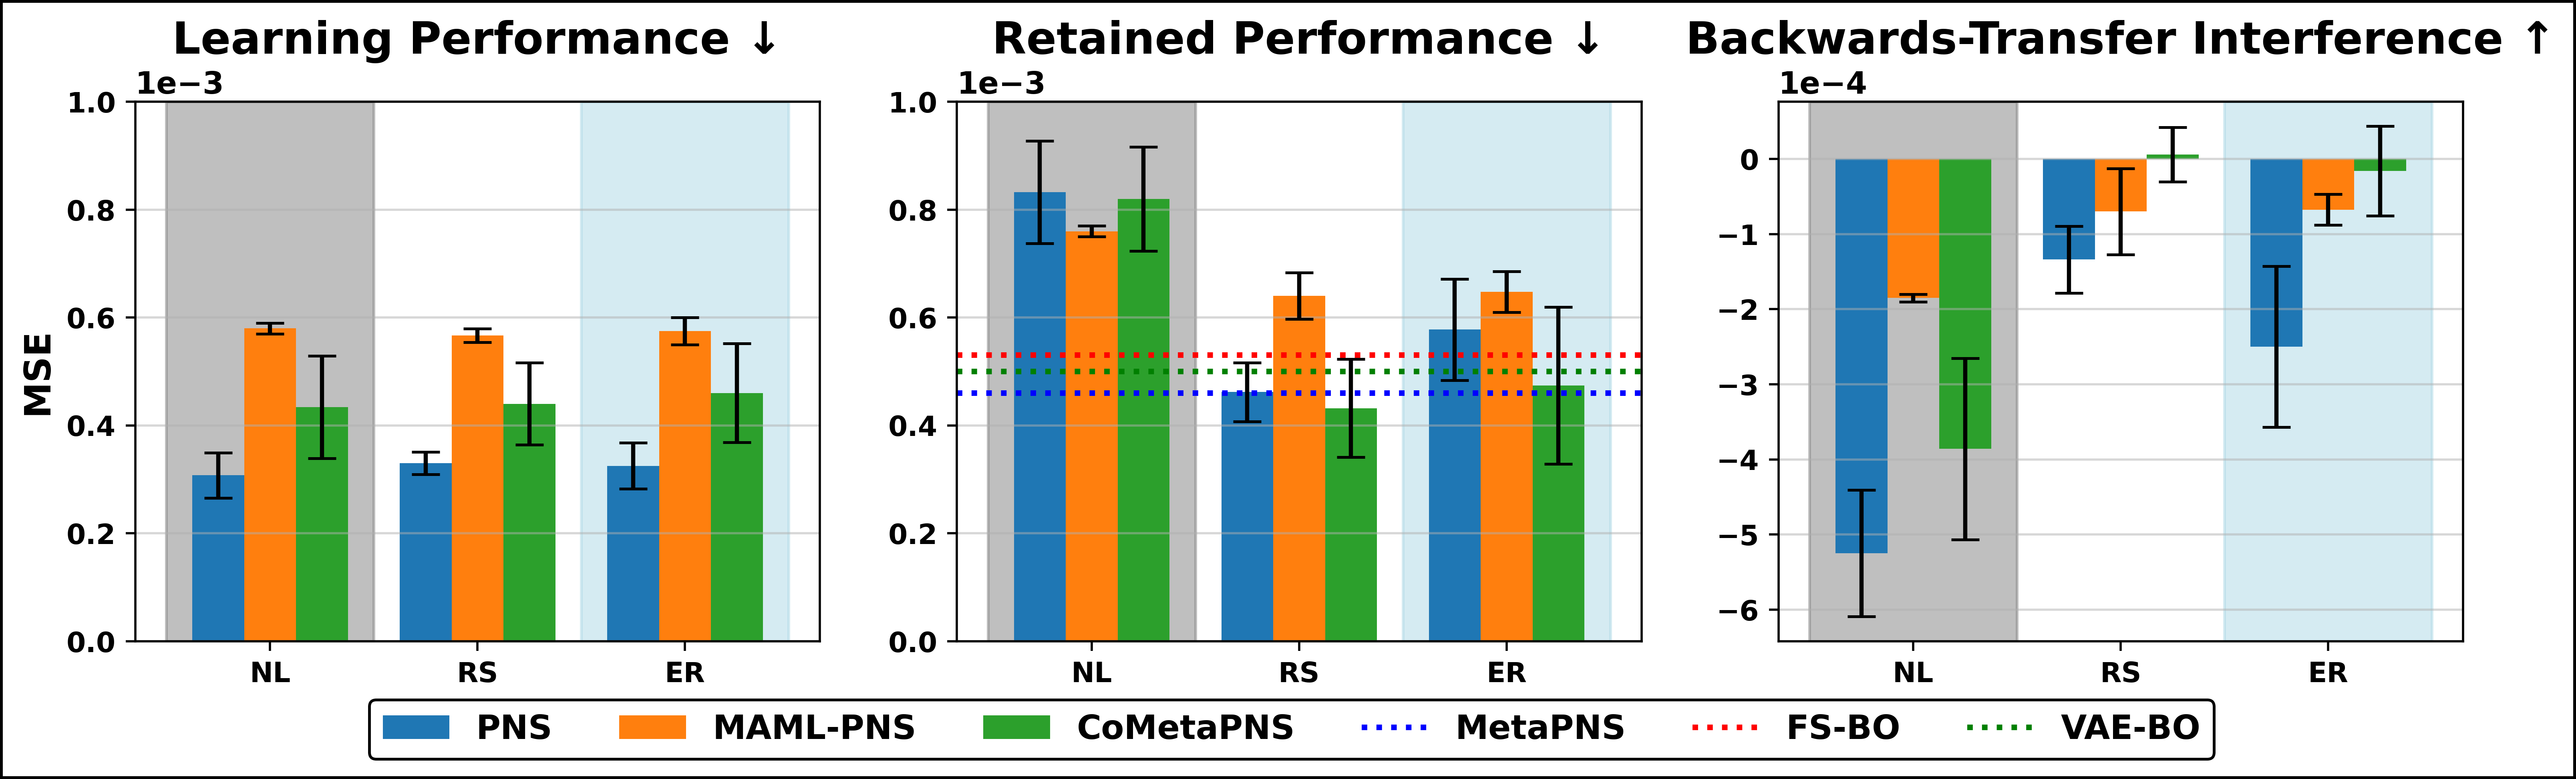

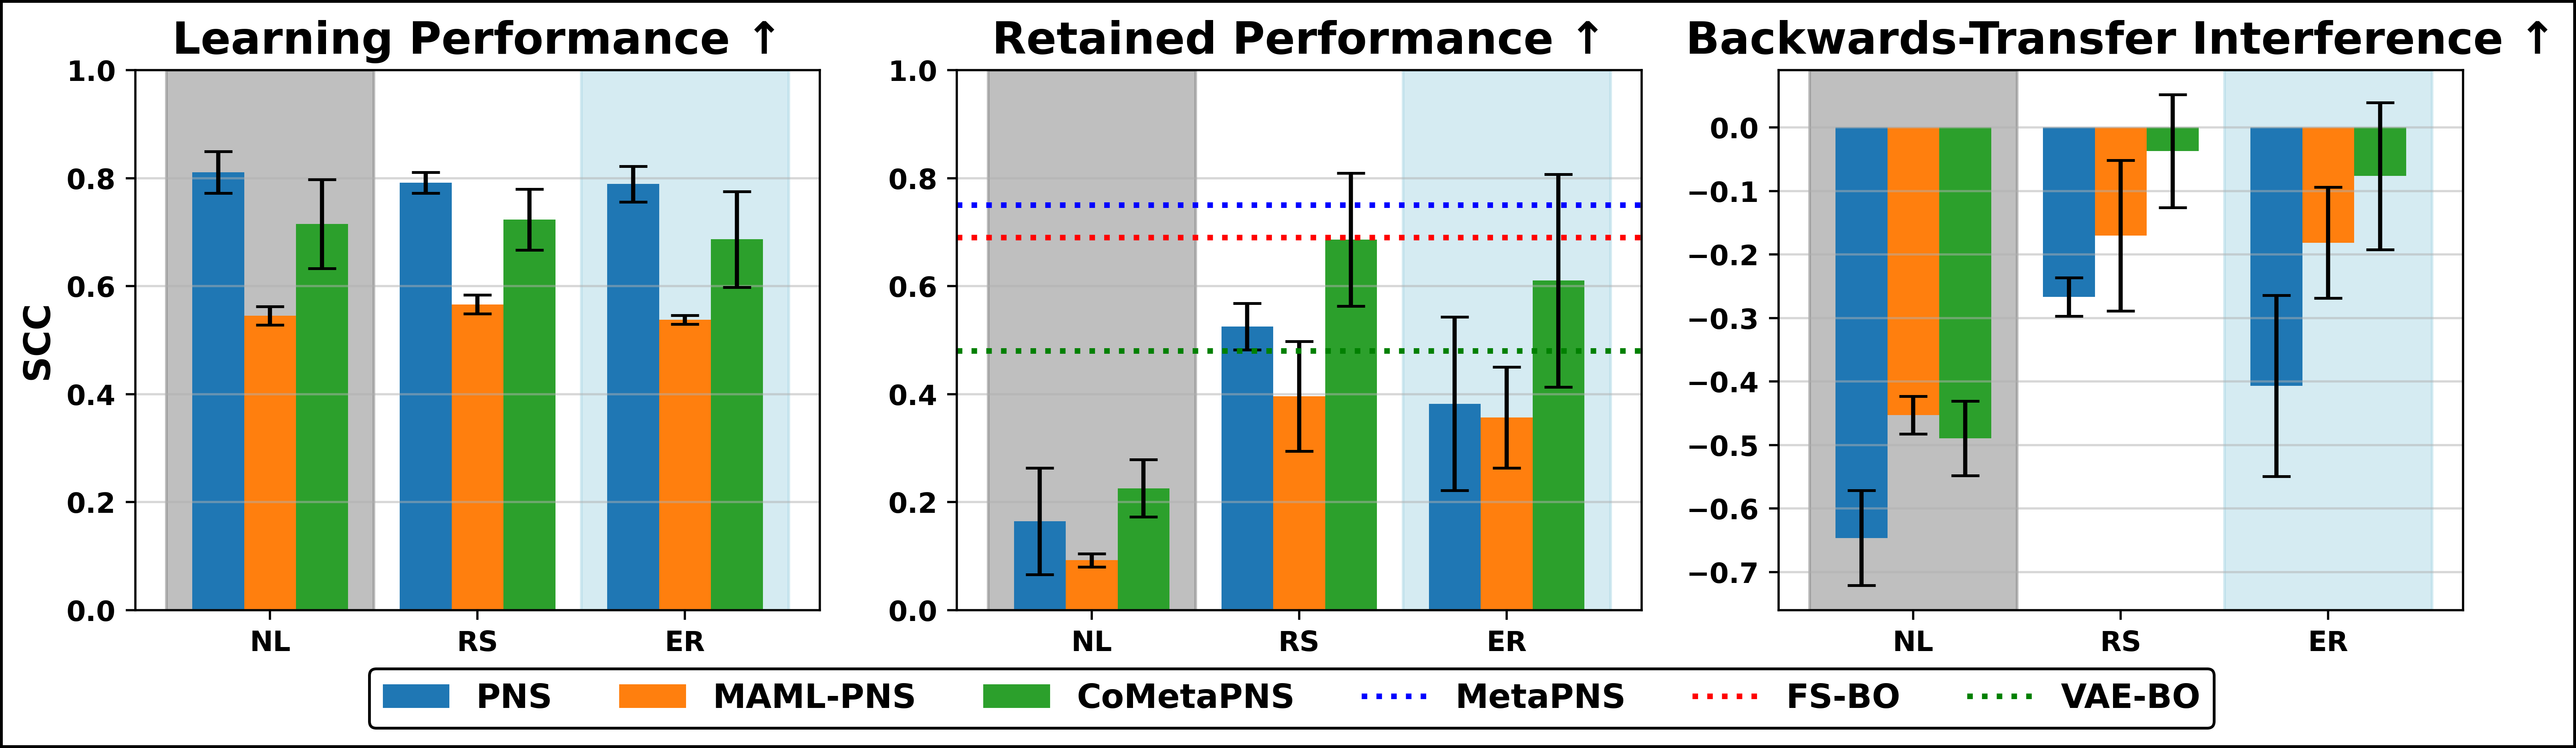

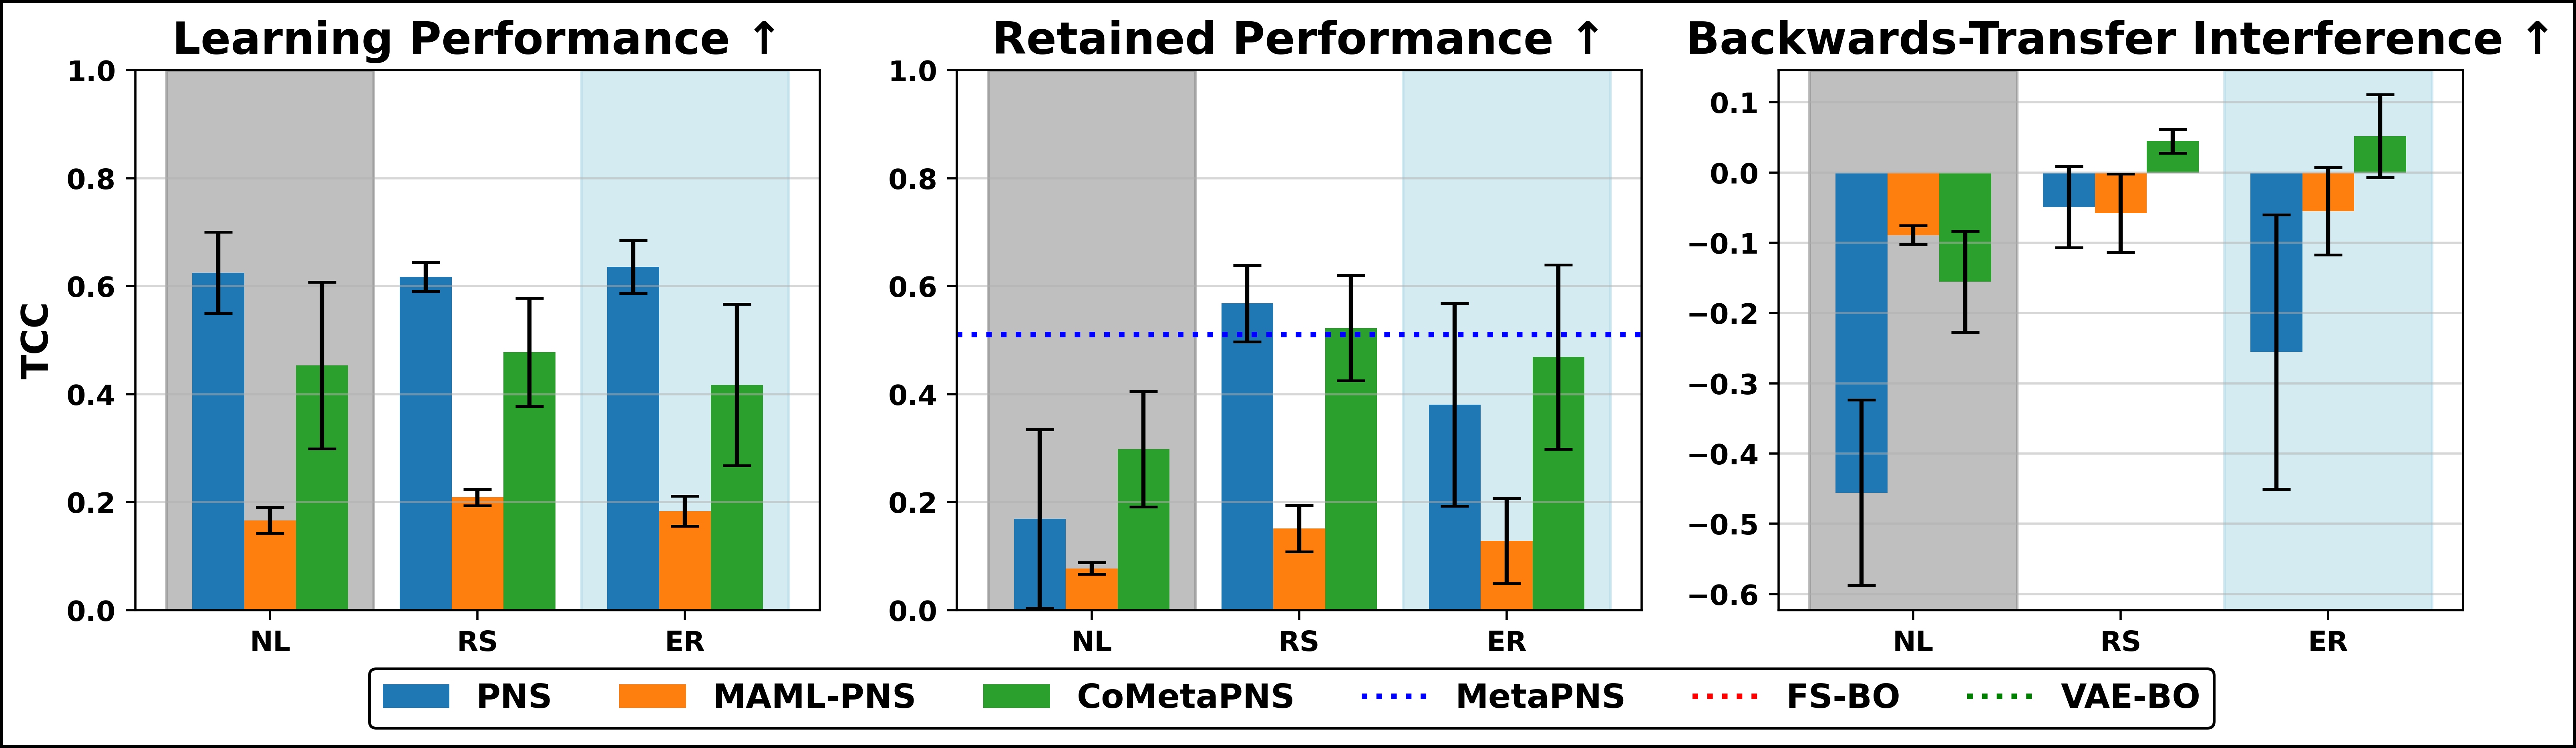

In [5]:
import matplotlib.pyplot as plt
import numpy as np

params = {'font.weight': 'bold'} 
plt.rcParams.update(params)

# Define baseline values for each metric type
baselines = {
    "MSE": {
        "MetaPNS": 0.00046,
        "FS-BO": 0.00053,
        "VAE-BO": 0.00050
    },
    "SCC": {
        "MetaPNS": 0.75,
        "FS-BO": 0.69,
        "VAE-BO": 0.48
    },
    "TCC": {
        "MetaPNS": 0.51,
        "FS-BO": -1,
        "VAE-BO": -1
    }
}

# Define line styles and colors for baselines
baseline_styles = {
    "FS-BO": {"color": "red", "linestyle": ":", "linewidth": 2},
    "VAE-BO": {"color": "green", "linestyle": ":", "linewidth": 2},
    "MetaPNS": {"color": "blue", "linestyle": ":", "linewidth": 2}
}

for metric_type in ["MSE", "SCC", "TCC"]:
    dataset = "synthetic"
    
    categories = ['NL', 'RS', 'ER']
    x = np.arange(len(categories))
    bar_width = 0.25
    offsets = [-bar_width, 0, bar_width]

    fig, axes = plt.subplots(1, 3, figsize=(15, 3.5), dpi=500, sharex=True)
    models = ["PNS", "MAML-PNS", "CoMetaPNS"]

    label_font_size = 13
    title_font_size = 16
    legend_font_size = 12

    if metric_type == "MSE":
        max_val = 0.001
    else:
        max_val = 1.0

    for i in range(3):
        axes[i].axvspan(-0.5, 0.5, color='gray', alpha=0.5)
        axes[i].axvspan(1.5, 2.5, color='lightblue', alpha=0.5)

    # In the plotting loop, modify this section:
    for plot_idx, perf_type in enumerate(["LP", "RP", "BTI"]):
        for i, model in enumerate(models):
            try:
                # Get memories in the correct order based on categories 
                means = []
                stds = []
                for mem in ['NL', 'RS', 'ER']:
                    mean = metrics[dataset][model][mem][perf_type][metric_type]["Mean"]
                    std = metrics[dataset][model][mem][perf_type][metric_type]["Std"]
                    means.append(mean)
                    stds.append(std)
        
                axes[plot_idx].bar(x + offsets[i], means, width=bar_width, 
                                label=model, yerr=stds, capsize=5)
            except Exception as e:
                print(f"Error plotting {model} {perf_type} {metric_type}: {str(e)}")
                continue

        # Add horizontal lines only for Retained Performance
        if perf_type == "RP":
            for baseline_name, value in baselines[metric_type].items():
                line = axes[plot_idx].axhline(
                    y=value,
                    **baseline_styles[baseline_name],
                    label=f"{baseline_name}"
                )

        direction = "↓" if metric_type == "MSE" else "↑"
        titles = {
            "LP": f'Learning Performance {direction}',
            "RP": f'Retained Performance {direction}',
            "BTI": f'Backwards-Transfer Interference ↑'
        }
        
        if metric_type == "MSE":
            # Set scientific notation for MSE plots
            axes[plot_idx].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
            axes[plot_idx].yaxis.get_offset_text().set_fontsize(11)
            axes[plot_idx].yaxis.get_offset_text().set_fontweight('bold')
        
        axes[plot_idx].set_title(titles[perf_type], fontsize=title_font_size, fontweight='bold')
        
        # Only set ylabel for leftmost subplot
        if plot_idx == 0:
            axes[plot_idx].set_ylabel(metric_type, fontsize=label_font_size, fontweight='bold')
        else:
            axes[plot_idx].set_ylabel('')  # Remove ylabel for other subplots
            
        axes[plot_idx].set_xticks(x)
        axes[plot_idx].set_xticklabels(categories, fontweight='bold')
        
        if perf_type in ["LP", "RP"]:
            axes[plot_idx].set_ylim(0, max_val)
            
        axes[plot_idx].grid(True, axis='y', alpha=0.5)

    # Get bar handles and baselines manually for legend
    bar_handles, bar_labels = axes[0].get_legend_handles_labels()
    
    # Add horizontal line handles manually
    all_handles = bar_handles + [
        plt.Line2D([0], [0], **baseline_styles["MetaPNS"]),
        plt.Line2D([0], [0], **baseline_styles["FS-BO"]),
        plt.Line2D([0], [0], **baseline_styles["VAE-BO"])
    ]
    all_labels = bar_labels + ["MetaPNS", "FS-BO", "VAE-BO"]

    legend = fig.legend(all_handles, all_labels,
                       loc='upper center', 
                       bbox_to_anchor=(0.51, 0.05), 
                       ncol=6,  # Show all items in one row 
                       fontsize=legend_font_size)

    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_alpha(1)

    fig.patch.set_linewidth(2)
    fig.patch.set_edgecolor('black')

    try:
        plt.savefig(f"continual_metric_{metric_type.lower()}_{dataset}_flattened.svg", 
                    bbox_inches="tight")
    except Exception as e:
        print(f"Error saving figure for {metric_type}: {str(e)}")
        
    plt.show()
    plt.close()

KeyError: 'mp'

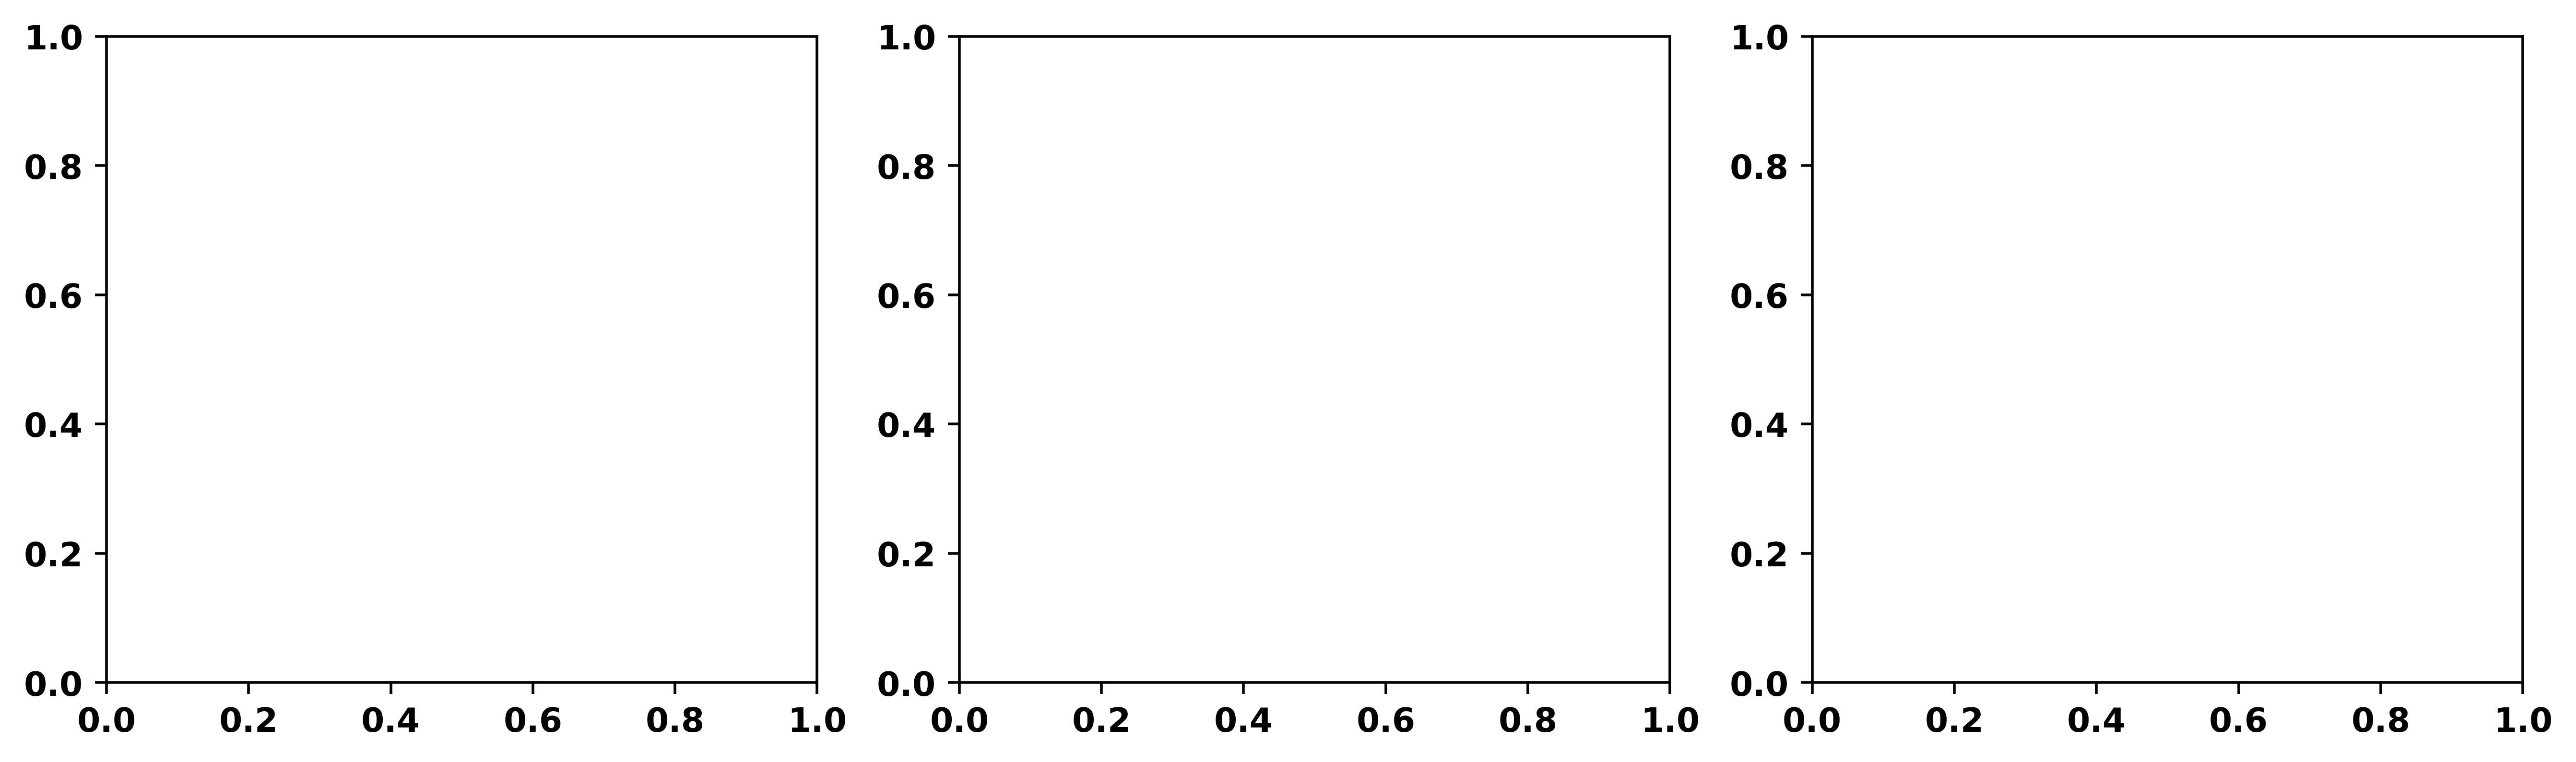

In [6]:
import matplotlib.pyplot as plt
import numpy as np

params = {'font.weight': 'bold'} 
plt.rcParams.update(params)

for metric_type in ["DST", "MSE"]:
    for dataset in ["mp", "g6_strict"]:
        # X-axis
        categories = ['NL', 'T-Agnostic', 'T-Aware', 'ER']
        x = np.arange(len(categories))  # Numeric indices for categories

        # Bar width and offset to plot bars next to each other within the same category
        bar_width = 0.2
        offsets = [-1.5 * bar_width, -0.5 * bar_width, 0.5 * bar_width, 1.5 * bar_width]  # Adjusted for 4 models

        # Create a figure with 3 subplots, sharing the same x-axis
        fig, axes = plt.subplots(1, 3, figsize=(13, 3.5), dpi=500, sharex=True)

        models = ["DKF", "VRNN", "RGNRes", "MetaRGNRes"]

        # Set a common font size for readability in a scientific paper
        label_font_size = 13
        title_font_size = 16
        legend_font_size = 12

        # Getting shared max ylims across LP and RP metrics
        max_val = -np.inf
        for model in models:
            for mem in metrics[dataset][model].keys():
                for met in ["LP", "RP"]:
                    if metrics[dataset][model][mem][met][metric_type]["Mean"] > max_val:
                        max_val = metrics[dataset][model][mem][met][metric_type]["Mean"]

        if metric_type == "DST":
            ylim_plus = 1
        else:
            ylim_plus = 0.005

        # Light shading for first and last category
        for i in range(3):  # Apply to all rows
            axes[i].axvspan(-0.5, 0.5, color='gray', alpha=0.5)  # First category
            axes[i].axvspan(2.5, 3.5, color='lightblue', alpha=0.5)  # Last category

        """ G6 """
        # Plot LP
        for i, model in enumerate(models):
            means = np.array([metrics[dataset][model][mem]["LP"][metric_type]["Mean"] for mem in metrics[dataset][model].keys()])
            stds = np.array([metrics[dataset][model][mem]["LP"][metric_type]["Std"] for mem in metrics[dataset][model].keys()])
            axes[0].bar(x + offsets[i], means, width=bar_width, label=model, yerr=stds, capsize=5)

        axes[0].set_title('Learning Performance ↓', fontsize=title_font_size, fontweight='bold')
        axes[0].set_ylabel(f"{metric_type}", fontsize=label_font_size, fontweight='bold')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(categories, fontweight='bold')
        axes[0].set_ylim(0, max_val + ylim_plus)
        axes[0].grid(True, axis='y', alpha=0.5)


        # Plot RP
        for i, model in enumerate(models):
            means = np.array([metrics[dataset][model][mem]["RP"][metric_type]["Mean"] for mem in metrics[dataset][model].keys()])
            stds = np.array([metrics[dataset][model][mem]["RP"][metric_type]["Std"] for mem in metrics[dataset][model].keys()])
            axes[1].bar(x + offsets[i], means, width=bar_width, label=model, yerr=stds, capsize=5)

        axes[1].set_title('Retained Performance ↓', fontsize=title_font_size, fontweight='bold')
        axes[1].set_ylabel(f"{metric_type}", fontsize=label_font_size, fontweight='bold')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(categories, fontweight='bold')
        axes[1].set_ylim(0, max_val + ylim_plus)  # Set ylim based on max value of Accuracy and Precision
        axes[1].grid(True, axis='y', alpha=0.5)

        # Plot BTI
        for i, model in enumerate(models):
            means = np.array([metrics[dataset][model][mem]["BTI"][metric_type]["Mean"] for mem in metrics[dataset][model].keys()])
            stds = np.array([metrics[dataset][model][mem]["BTI"][metric_type]["Std"] for mem in metrics[dataset][model].keys()])
            axes[2].bar(x + offsets[i], means, width=bar_width, label=model, yerr=stds, capsize=5)

        axes[2].set_title('Backwards-Transfer Interference ↑', fontsize=title_font_size, fontweight='bold')
        axes[2].set_ylabel(f"{metric_type}", fontsize=label_font_size, fontweight='bold')
        axes[2].set_xticks(x)
        axes[2].set_xticklabels(categories, fontweight='bold')
        axes[2].grid(True, axis='y', alpha=0.5)

        # Draw bounding boxes around the two dataset columns
        # Bounding box for 'mp'
        # bbox_mp = plt.Rectangle((0.005, 0.00), 1.0, 0.90, edgecolor='black', fill=False, lw=2, transform=fig.transFigure)
        # fig.patches.append(bbox_mp)

        # Create a shared legend between the two columns, centered in the figure
        handles, labels = axes[0].get_legend_handles_labels()  # Get handles and labels from one of the plots
        legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.54, 0.05), ncol=len(models), fontsize=legend_font_size)

        # Customize legend to block out lines behind it
        legend.get_frame().set_facecolor('white')  # Set solid white background
        legend.get_frame().set_edgecolor('black')  # Add black border around the legend
        legend.get_frame().set_alpha(1)  # Ensure no transparency

        # Adjust layout to prevent overlap and make room for the bounding boxes, titles, and shared legend
        plt.tight_layout()  # Increased bottom space for the legend

        fig.patch.set_linewidth(2)
        fig.patch.set_edgecolor('black')

        # Show the plot
        plt.savefig(f"continual_metric_update_nonCML_{metric_type.lower()}_{dataset}_flattened.svg", bbox_inches="tight")
        plt.show()
        plt.close()

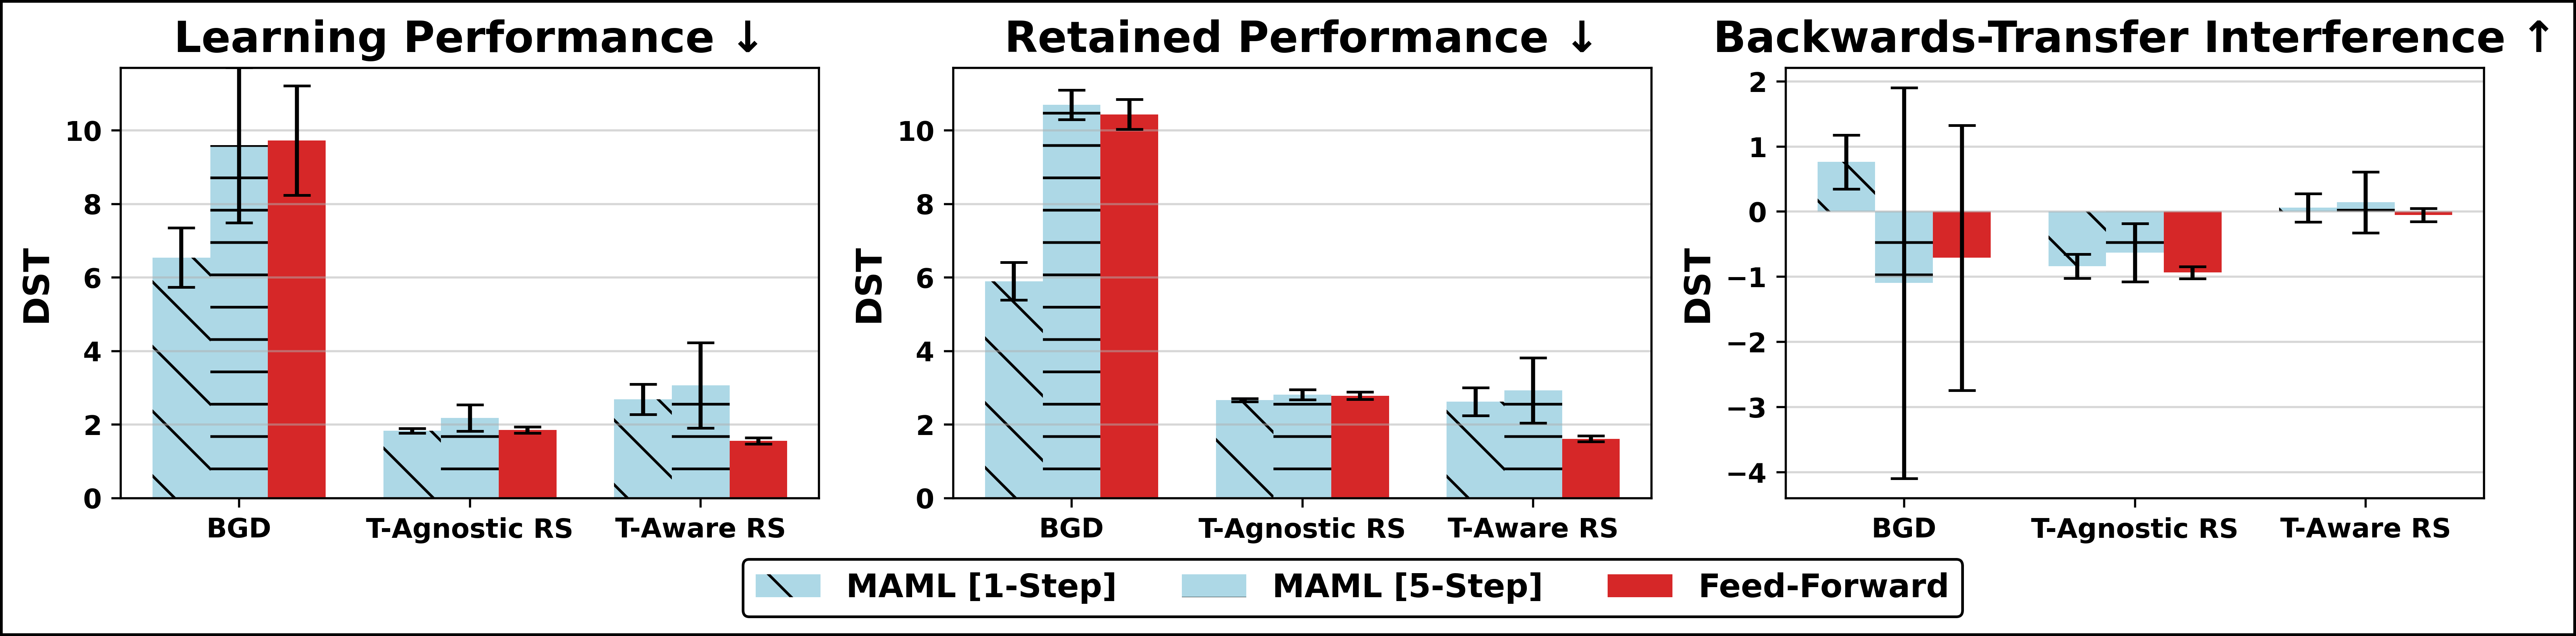

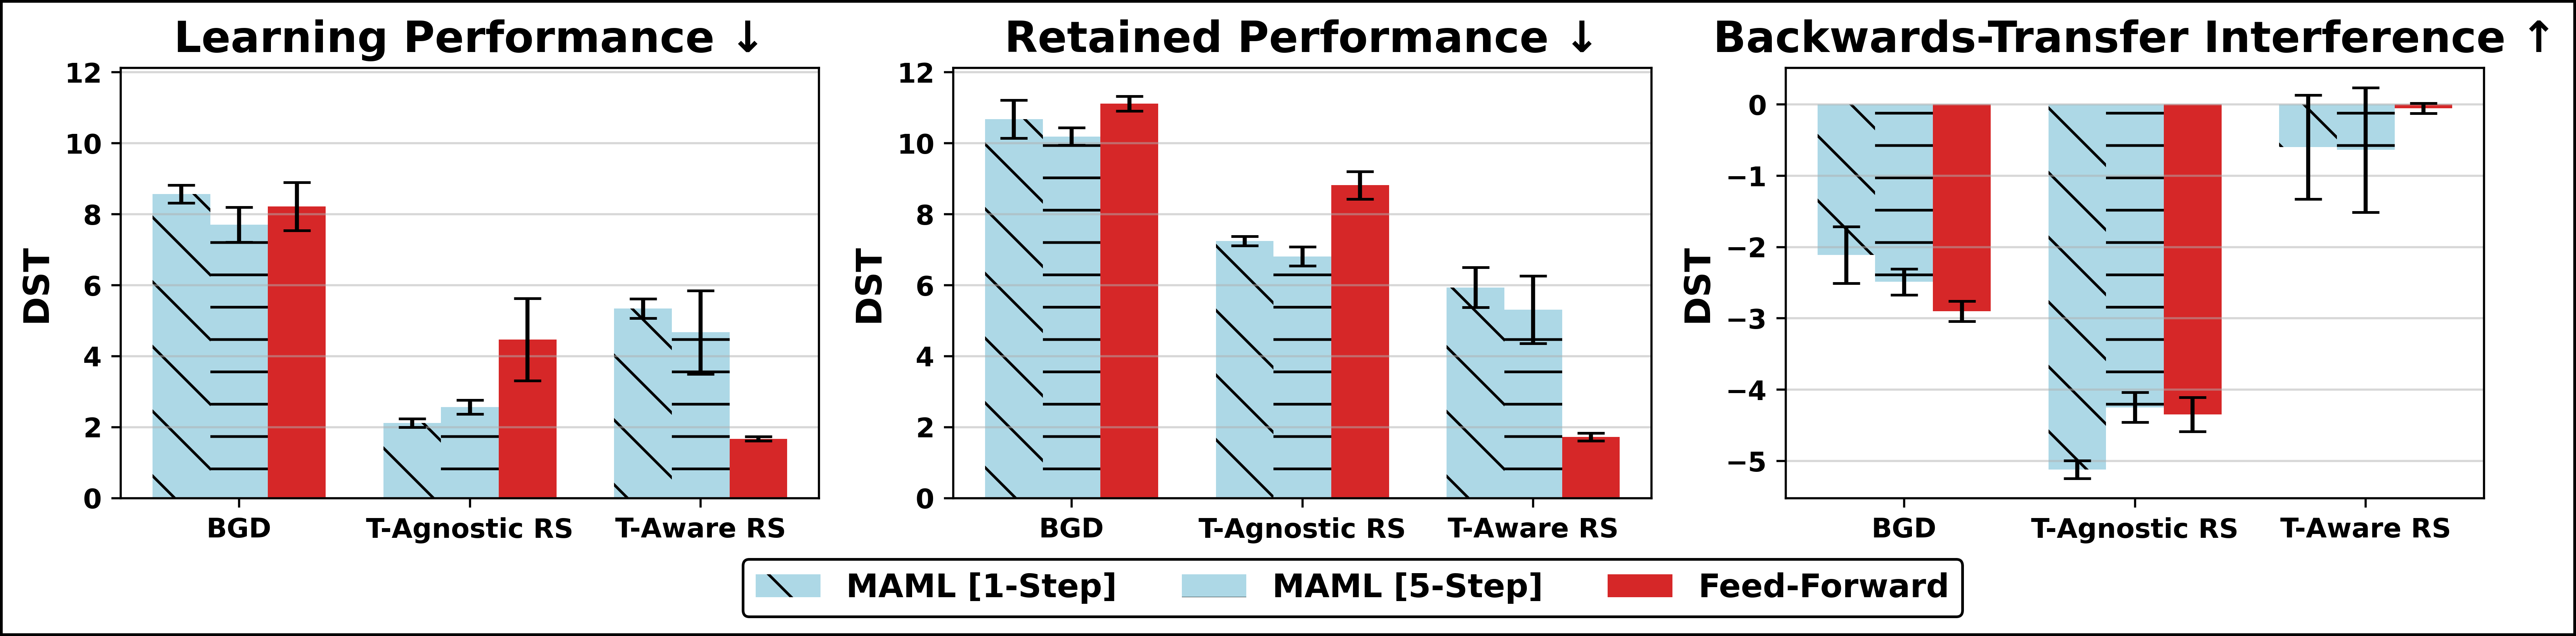

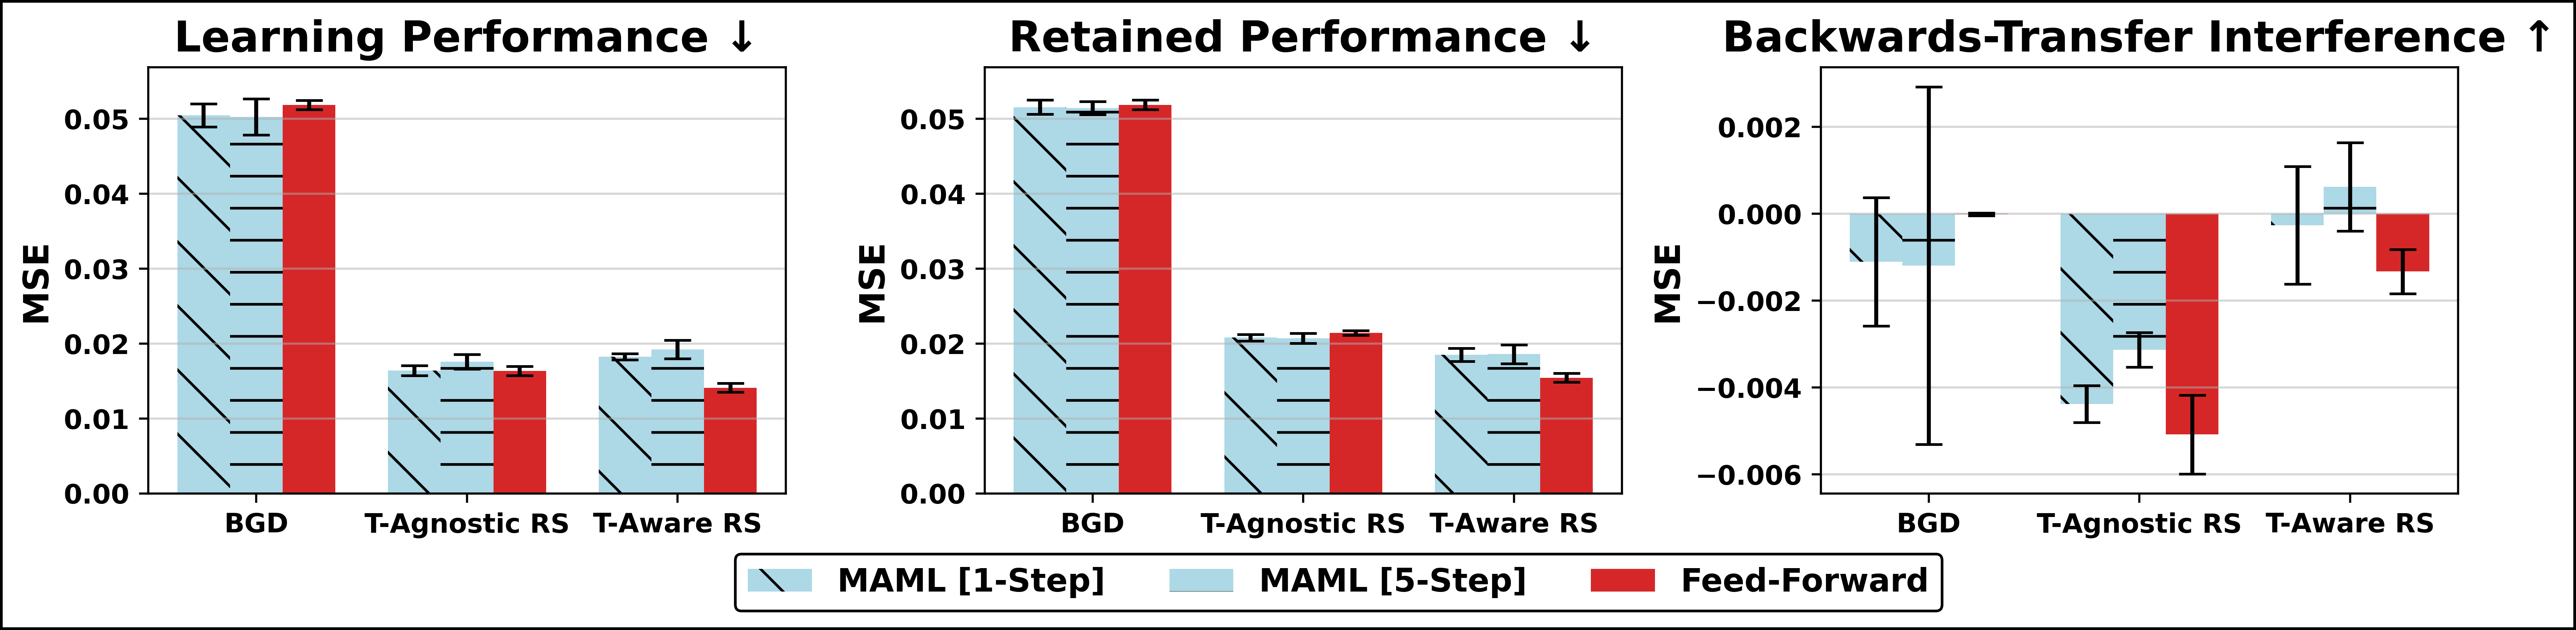

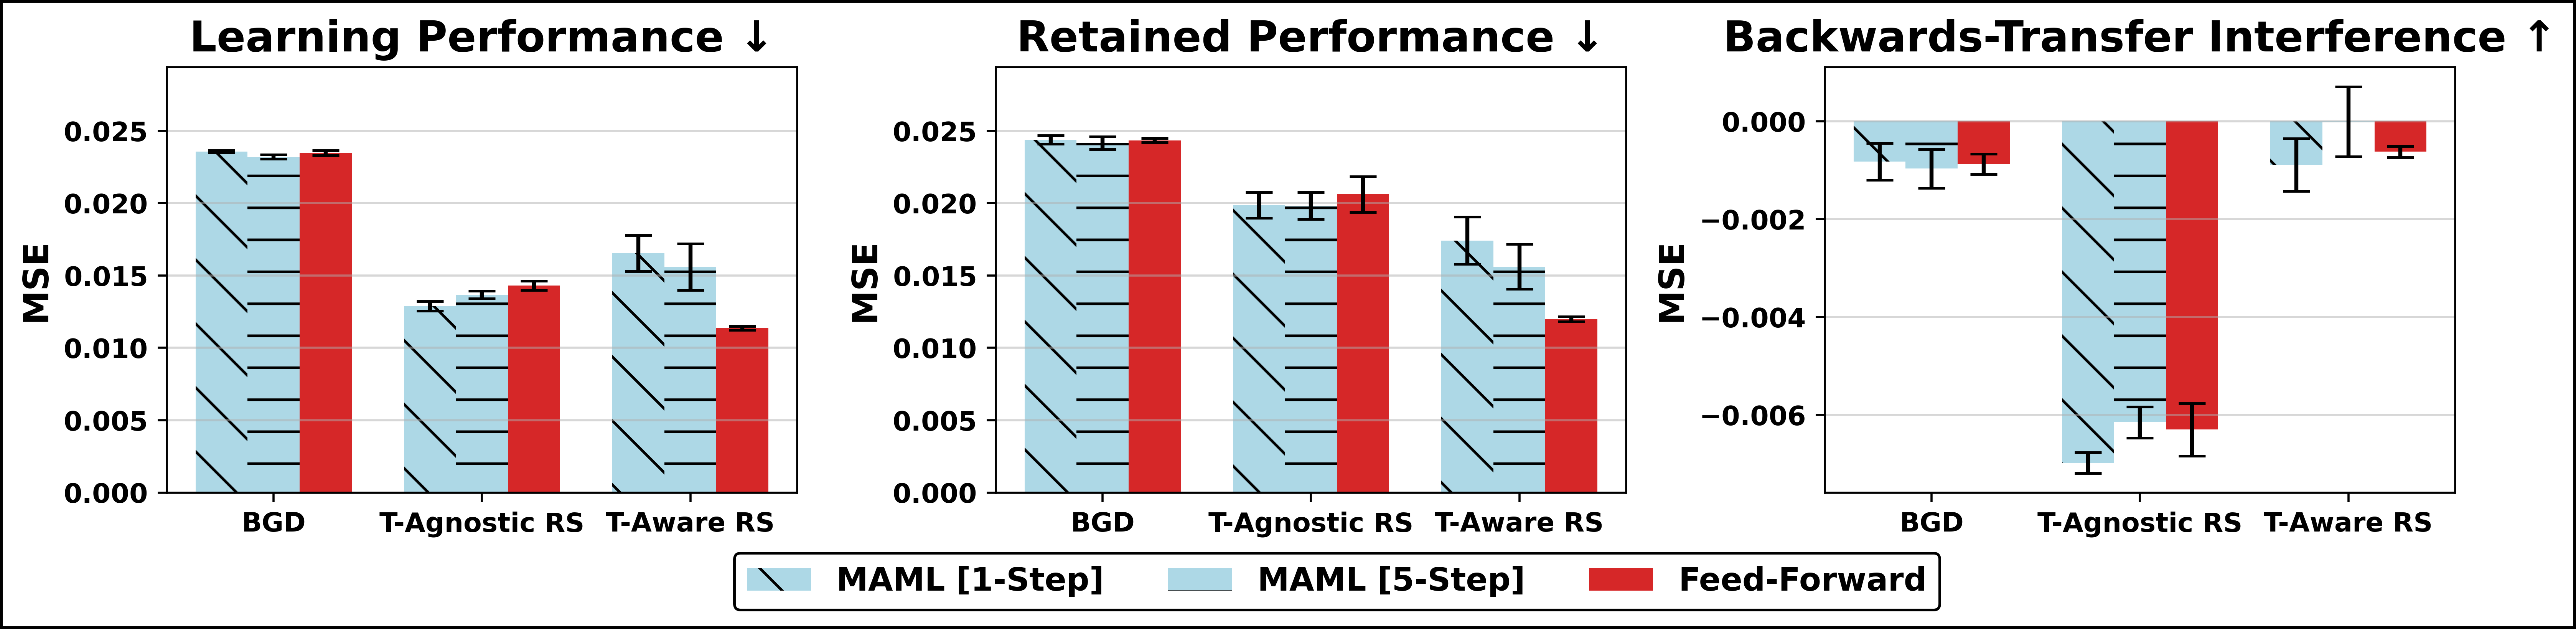

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

params = {'font.weight': 'bold'} 
plt.rcParams.update(params)

for metric_type in ["DST", "MSE"]:
    for dataset in ["mp", "g6_strict"]:
        # X-axis
        categories = ['BGD', 'T-Agnostic RS', 'T-Aware RS']
        x = np.arange(len(categories))  # Numeric indices for categories

        # Bar width and offset to plot bars next to each other within the same category
        bar_width = 0.25
        offsets = [-bar_width, 0, bar_width]

        # Create a figure with 3 subplots, sharing the same x-axis
        fig, axes = plt.subplots(1, 3, figsize=(13, 3), dpi=500, sharex=True)

        models = ['MAML [1-Step]', 'MAML [5-Step]', "Feed-Forward"]
        colors = ['lightblue', 'lightblue', '#d62728']
        hatching = ["\\", "-", ""]

        # Set a common font size for readability in a scientific paper
        label_font_size = 13
        title_font_size = 16
        legend_font_size = 12

        # Getting shared max ylims across LP and RP metrics
        max_val = -np.inf
        for model in models:
            for mem in metrics[dataset][model].keys():
                for met in ["LP", "RP"]:
                    if metrics[dataset][model][mem][met][metric_type]["Mean"] > max_val:
                        max_val = metrics[dataset][model][mem][met][metric_type]["Mean"]

        if metric_type == "DST":
            ylim_plus = 1
        else:
            ylim_plus = 0.005

        """ G6 """
        # Plot LP
        for i, (model, color, hatch) in enumerate(zip(models, colors, hatching)):
            means = np.array([metrics[dataset][model][mem]["LP"][metric_type]["Mean"] for mem in metrics[dataset][model].keys()])
            stds = np.array([metrics[dataset][model][mem]["LP"][metric_type]["Std"] for mem in metrics[dataset][model].keys()])
            axes[0].bar(x + offsets[i], means, width=bar_width, label=model, yerr=stds, capsize=5, color=color, hatch=hatch)

        axes[0].set_title('Learning Performance ↓', fontsize=title_font_size, fontweight='bold')
        axes[0].set_ylabel(f"{metric_type}", fontsize=label_font_size, fontweight='bold')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(categories, fontweight='bold')
        axes[0].set_ylim(0, max_val + ylim_plus)
        axes[0].grid(True, axis='y', alpha=0.5)


        # Plot RP
        for i, (model, color, hatch) in enumerate(zip(models, colors, hatching)):
            means = np.array([metrics[dataset][model][mem]["RP"][metric_type]["Mean"] for mem in metrics[dataset][model].keys()])
            stds = np.array([metrics[dataset][model][mem]["RP"][metric_type]["Std"] for mem in metrics[dataset][model].keys()])
            axes[1].bar(x + offsets[i], means, width=bar_width, label=model, yerr=stds, capsize=5, color=color, hatch=hatch)

        axes[1].set_title('Retained Performance ↓', fontsize=title_font_size, fontweight='bold')
        axes[1].set_ylabel(f"{metric_type}", fontsize=label_font_size, fontweight='bold')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(categories, fontweight='bold')
        axes[1].set_ylim(0, max_val + ylim_plus)  # Set ylim based on max value of Accuracy and Precision
        axes[1].grid(True, axis='y', alpha=0.5)

        # Plot BTI
        for i, (model, color, hatch) in enumerate(zip(models, colors, hatching)):
            means = np.array([metrics[dataset][model][mem]["BTI"][metric_type]["Mean"] for mem in metrics[dataset][model].keys()])
            stds = np.array([metrics[dataset][model][mem]["BTI"][metric_type]["Std"] for mem in metrics[dataset][model].keys()])
            axes[2].bar(x + offsets[i], means, width=bar_width, label=model, yerr=stds, capsize=5, color=color, hatch=hatch)

        axes[2].set_title('Backwards-Transfer Interference ↑', fontsize=title_font_size, fontweight='bold')
        axes[2].set_ylabel(f"{metric_type}", fontsize=label_font_size, fontweight='bold')
        axes[2].set_xticks(x)
        axes[2].set_xticklabels(categories, fontweight='bold')
        axes[2].grid(True, axis='y', alpha=0.5)

        # Draw bounding boxes around the two dataset columns
        # Bounding box for 'mp'
        # bbox_mp = plt.Rectangle((0.005, 0.00), 1.0, 0.90, edgecolor='black', fill=False, lw=2, transform=fig.transFigure)
        # fig.patches.append(bbox_mp)

        # Create a shared legend between the two columns, centered in the figure
        handles, labels = axes[0].get_legend_handles_labels()  # Get handles and labels from one of the plots
        legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.54, 0.05), ncol=len(models), fontsize=legend_font_size)

        # Customize legend to block out lines behind it
        legend.get_frame().set_facecolor('white')  # Set solid white background
        legend.get_frame().set_edgecolor('black')  # Add black border around the legend
        legend.get_frame().set_alpha(1)  # Ensure no transparency

        # Adjust layout to prevent overlap and make room for the bounding boxes, titles, and shared legend
        plt.tight_layout()
        
        fig.patch.set_linewidth(2)
        fig.patch.set_edgecolor('black')

        # Show the plot
        plt.savefig(f"continual_metric_CML_{metric_type.lower()}_{dataset}_flattened.svg", bbox_inches="tight")
        plt.show()
        plt.close()